# Independent Work Project
The goal of this project is to use methods in data science to predict the probability that every player in the first round of the 2019 NBA draft makes an All-NBA team throughout their careers.

### Anaconda
We will use the Anaconda platform for Python for this project

In [268]:
%matplotlib inline

def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import RFE
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import ADASYN

# Flags
include_woh  = True
include_pick = True

### Loading and preparing the data for analysis
The data consists of the college basketball statistics of all first round picks who have played in the NCAA, since the 1990 NBA Draft. The columns consist of:
* Points per game
* Rebounds per game
* Assists per game
* Steals per game
* etc.

In [269]:
# Loading data as Pandas dataframe
filename = 'data.csv' if include_woh else 'data_raw.csv'
df = pd.read_csv(filename, header=0)
if not include_pick: df = df.drop(['Pick'], axis=1)
df.head()

,Player,Pick,RPG,APG,SPG,BPG,PPG,SOS,TS%,FTr,W/H,Age,All-NBA
0,Derrick Coleman,1,12.1,2.9,1.5,2.0,17.9,8.85,0.620,0.747,2.80,23,1
1,Gary Payton,2,4.7,8.1,3.4,0.5,25.7,6.91,0.572,0.299,2.37,22,1
2,Mahmoud Abdul-Rauf,3,2.5,3.2,1.6,0.0,27.8,7.61,0.584,0.317,2.22,21,0
3,Dennis Scott,4,6.6,2.0,1.8,0.9,27.7,10.33,0.593,0.281,2.86,22,0
4,Kendall Gill,5,4.9,3.3,2.2,0.6,20.0,9.89,0.575,0.415,2.53,22,0


In [270]:
df = df._get_numeric_data()
headers = list(df.columns)
dataset = df.to_numpy()
y_i = headers.index('All-NBA')
    
# Separate data into features and target
x = dataset[:, 0:y_i]
y = dataset[:, y_i]

# Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, stratify=y, random_state=42)

# Predictive Models
We will use the following models for the following reasons...

## 1. Logistic Regression Model
Our first model will be a logistic regression model, using the default sklearn parameters.


In [271]:
log = Pipeline([
    ('scaler', StandardScaler()),
    ('RFE', RFE(LogisticRegression(solver='liblinear'))),
    ('LOG', LogisticRegression(solver='liblinear'))
])

log_os = Pipeline([
    ('scaler', StandardScaler()),
    ('OS', ADASYN()),
    ('RFE', RFE(LogisticRegression(solver='liblinear'))),
    ('LOG', LogisticRegression(solver='liblinear'))
])

n_features_to_select = [5,6,7,8,9]
penalty = ['l1', 'l2']
C = [0.001, 0.1, 1, 10, 100, 1000]

param_grid = [
    {
        'RFE__n_features_to_select': n_features_to_select,
        'LOG__penalty': penalty,
        'LOG__C': C
    }
]

model_log = GridSearchCV(log, param_grid=param_grid, cv=5, scoring='f1')
model_log_os = GridSearchCV(log_os, param_grid=param_grid, cv=5, scoring='f1')

## 2. Random Forest Classifier
For the Random Forest Classifier (RFC) we use randomized search with cross validation to achieve a shorter training time.

In [272]:
rfc = Pipeline([
    ('scaler', StandardScaler()),
    ('RFE', RFE(RandomForestClassifier(n_estimators=10))),
    ('RFC', RandomForestClassifier())  
])

rfc_os = Pipeline([
    ('scaler', StandardScaler()),
    ('OS', ADASYN()),
    ('RFE', RFE(RandomForestClassifier(n_estimators=10))),
    ('RFC', RandomForestClassifier())
])

n_features_to_select = [5, 6, 7, 8, 9]
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 200, num = 15)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 50, num = 10)]
max_depth.append(None)
                
param_grid = {
    'RFE__n_features_to_select': n_features_to_select,
    'RFC__n_estimators': n_estimators,
    'RFC__max_features': max_features,
    'RFC__max_depth': max_depth
}
                
model_rfc_os = RandomizedSearchCV(rfc_os, param_distributions=param_grid, cv=3, n_iter=50, scoring='f1')
model_rfc = RandomizedSearchCV(rfc, param_distributions=param_grid, cv=3, n_iter=50, scoring='f1')

In [273]:
# If using grid search for Random Forest Classifier:
'''
param_grid = {
    'RFE__n_features_to_select': [6, 7, 8],
    'RFC__max_features': ['auto', 'sqrt'],
    'RFC__max_depth': [10, 15, 20],
    'RFC__n_estimators': [40, 45, 50, 55]
}

model_rfc_os = GridSearchCV(rfc_os, param_grid=param_grid, cv=5, scoring='f1')
model_rfc = GridSearchCV(rfc, param_grid=param_grid, cv=5, scoring='f1')
'''

"\nparam_grid = {\n    'RFE__n_features_to_select': [6, 7, 8],\n    'RFC__max_features': ['auto', 'sqrt'],\n    'RFC__max_depth': [10, 15, 20],\n    'RFC__n_estimators': [40, 45, 50, 55]\n}\n\nmodel_rfc_os = GridSearchCV(rfc_os, param_grid=param_grid, cv=5, scoring='f1')\nmodel_rfc = GridSearchCV(rfc, param_grid=param_grid, cv=5, scoring='f1')\n"

# Evaluating the Models
We will now look at a few methods of evaluating the models we've created

In [274]:
# Evaluation method
def evaluate(model, model_name, RFE=True):
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    
    # Confusion matrix
    xlabels=['Predicted 0', 'Predicted 1']
    ylabels=['Actual 0', 'Actual 1']
    
    plt.subplot(121, aspect='equal')
    plt.title('Confusion Matrix - %s' % model_name)
    cm = confusion_matrix(y_test, pred)
    df_cm = pd.DataFrame(cm, range(2), range(2))
    ax = sn.heatmap(df_cm, annot=True, xticklabels=xlabels, yticklabels=ylabels, cbar=False)
    ax.set_ylim(2, 0) # workaround for cut-off bug
    
    # ROC Curve
    probs = model.predict_proba(x_test)[:,1]
    fpr, tpr, threshold = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)
    
    plt.subplot(122, aspect='equal')
    plt.title('ROC Curve - %s' % model_name)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    
    plt.tight_layout()
    plt.show()
    
    
    # Accuracy, recall, precision and F1, and best parameters
    print('Accuracy of "%s" model: %.3f' % (model_name, metrics.accuracy_score(y_test, pred)))
    print('Recall of "%s" model: %.3f' % (model_name, metrics.recall_score(y_test, pred)))
    print('Precision of "%s" model: %.3f' % (model_name, metrics.precision_score(y_test, pred)))
    print('F1 of "%s" model: %.3f' % (model_name, metrics.f1_score(y_test, pred)))
    
    # If the model used feature selection:
    if RFE:
        print('\n')
        print('Hyperparameters:',model.best_params_)
        rfe = model.best_estimator_.named_steps['RFE']
        print('Selected features:',[headers[i] for i in rfe.get_support(indices=True)])
        

### Dummy Classifier
A dummy classifier assigns labels randomly, according to the distribution of classes in the training set

In [275]:
dummy = DummyClassifier(strategy='stratified')

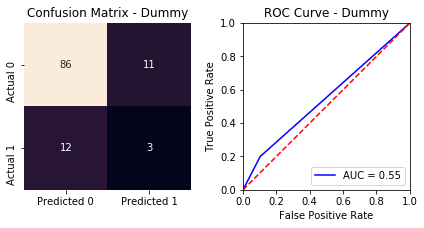

Accuracy of "Dummy" model: 0.795
Recall of "Dummy" model: 0.200
Precision of "Dummy" model: 0.214
F1 of "Dummy" model: 0.207


In [276]:
evaluate(dummy, 'Dummy', RFE=False)

## Logistic Regression
LOG model, with and without ADASYN oversampling

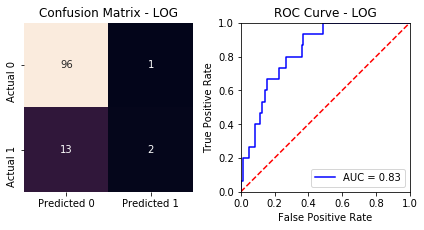

Accuracy of "LOG" model: 0.875
Recall of "LOG" model: 0.133
Precision of "LOG" model: 0.667
F1 of "LOG" model: 0.222


Hyperparameters: {'LOG__C': 1, 'LOG__penalty': 'l2', 'RFE__n_features_to_select': 9}
Selected features: ['Pick', 'RPG', 'APG', 'SPG', 'BPG', 'SOS', 'FTr', 'W/H', 'Age']


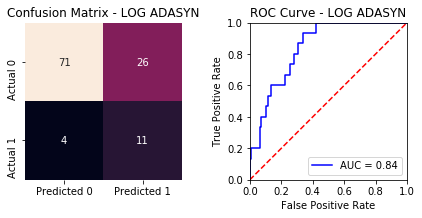

Accuracy of "LOG ADASYN" model: 0.732
Recall of "LOG ADASYN" model: 0.733
Precision of "LOG ADASYN" model: 0.297
F1 of "LOG ADASYN" model: 0.423


Hyperparameters: {'LOG__C': 1, 'LOG__penalty': 'l2', 'RFE__n_features_to_select': 6}
Selected features: ['Pick', 'RPG', 'APG', 'SPG', 'W/H', 'Age']


In [277]:
evaluate(model_log, 'LOG')
evaluate(model_log_os, 'LOG ADASYN')

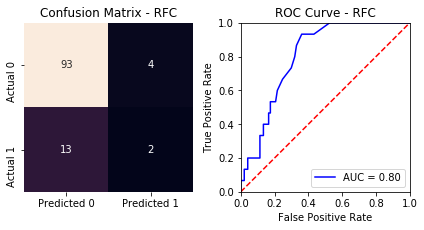

Accuracy of "RFC" model: 0.848
Recall of "RFC" model: 0.133
Precision of "RFC" model: 0.333
F1 of "RFC" model: 0.190


Hyperparameters: {'RFE__n_features_to_select': 4, 'RFC__n_estimators': 82, 'RFC__max_features': 'sqrt', 'RFC__max_depth': 45}
Selected features: ['Pick', 'APG', 'FTr', 'W/H']


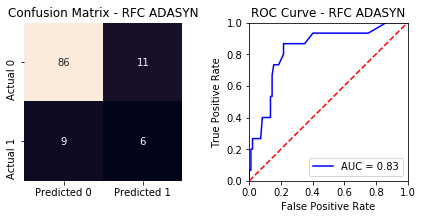

Accuracy of "RFC ADASYN" model: 0.821
Recall of "RFC ADASYN" model: 0.400
Precision of "RFC ADASYN" model: 0.353
F1 of "RFC ADASYN" model: 0.375


Hyperparameters: {'RFE__n_features_to_select': 5, 'RFC__n_estimators': 60, 'RFC__max_features': 'sqrt', 'RFC__max_depth': 36}
Selected features: ['Pick', 'RPG', 'APG', 'BPG', 'Age']


In [278]:
evaluate(model_rfc, 'RFC')
evaluate(model_rfc_os, 'RFC ADASYN')

# Results on 2019 Rookies

In [279]:
# Loading data as Pandas dataframe
filename = 'rookies.csv' if include_woh else 'rookies_raw.csv'
df = pd.read_csv(filename, header=0)
if not include_pick: df = df.drop(['Pick'], axis=1)
stats = df._get_numeric_data()
rookies = stats.to_numpy()

def pred_rookies(model, model_name):
    pred = model.predict_proba(rookies)

    print('Predicted probabilities (%s)' % model_name)
    print('==================================')
    for i in range(len(pred)):
        print('%-27s %.2f ' % (df['Player'][i], pred[i][1]))

In [280]:
pred_rookies(model_log, "LOG")
pred_rookies(model_log_os, "LOG ADASYN")
pred_rookies(model_rfc, "RFC")
pred_rookies(model_rfc_os, "RFC ADASYN")

Predicted probabilities (LOG)
Zion Williamson             0.83 
Ja Morant                   0.84 
RJ Barrett                  0.35 
De'Andre Hunter             0.06 
Darius Garland              0.11 
Jarrett Culver              0.21 
Coby White                  0.14 
Jaxson Hayes                0.05 
Rui Hachimura               0.06 
Cam Reddish                 0.07 
Cameron Johnson             0.02 
PJ Washington               0.04 
Tyler Herro                 0.05 
Romeo Langford              0.03 
Chuma Okeke                 0.04 
Nickeil Alexander-Walker    0.04 
Matisse Thybulle            0.04 
Predicted probabilities (LOG ADASYN)
Zion Williamson             0.99 
Ja Morant                   0.96 
RJ Barrett                  0.82 
De'Andre Hunter             0.26 
Darius Garland              0.38 
Jarrett Culver              0.65 
Coby White                  0.50 
Jaxson Hayes                0.22 
Rui Hachimura               0.26 
Cam Reddish                 0.34 
Cameron Johnson